In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from data_processing import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from data_transformar import *
import lightgbm as lgb
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor, Pool

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

In [4]:
from sklearn.metrics import mean_squared_error

cheat = pd.read_csv("./result-with-best.csv")

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cheat_score(model, val):
    print("RMSLE sub: " + str(rmsle(model.predict(val), np.log1p(cheat["SalePrice"]))))

def to_categorical(X):
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')

def evaluate(model, X, y):
    preds = model.predict(X)
    print("RMSLE: " + str(rmsle(preds, y)))

In [13]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

data = remove_outliers(data, True)

y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98987)
X_train_orig = X_train.copy()

transformer = DataTransformer(StandardScaler())

X_train = transformer.prepare(X_train)
X_test = transformer.prepare(X_test)

transformer.fit(X_train)

X_train = transformer.transform(X_train, False)
X_test = transformer.transform(X_test, False)

Int64Index([523, 1298], dtype='int64')


In [14]:
cat_features = np.where(X_train.loc[:, X_train.columns.values].dtypes == "object")[0]
X_train.iloc[:, cat_features]

,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
1353,RL,Pave,None,IR1,Lvl,CulDSac,Gtl,NoRidge,Norm,Norm,...,TA,TA,Y,None,None,None,3,2010,WD,Normal
737,RL,Pave,None,IR1,HLS,CulDSac,Gtl,Gilbert,Norm,Norm,...,TA,TA,Y,None,None,None,6,2006,WD,Normal
1014,RL,Pave,None,Reg,Lvl,Inside,Gtl,NAmes,Artery,Norm,...,TA,TA,Y,None,None,None,11,2007,WD,Normal
903,RL,Pave,None,IR1,HLS,CulDSac,Gtl,Gilbert,Norm,Norm,...,TA,TA,Y,None,None,None,8,2006,New,Partial
1160,RL,Pave,None,Reg,Lvl,Inside,Gtl,NPkVill,Norm,Norm,...,TA,TA,Y,None,None,None,7,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,RL,Pave,None,IR1,Lvl,Inside,Gtl,Timber,Norm,Norm,...,TA,TA,Y,None,None,None,6,2009,WD,Normal
1289,RL,Pave,None,IR1,Lvl,Inside,Gtl,NridgHt,Norm,Norm,...,TA,TA,Y,None,None,None,10,2006,New,Partial
180,FV,Pave,None,Reg,Lvl,Inside,Gtl,Somerst,Norm,Norm,...,TA,TA,Y,None,None,None,6,2007,WD,Normal
1291,RM,Pave,None,Reg,Lvl,Inside,Gtl,BrDale,Norm,Norm,...,TA,TA,Y,None,None,None,2,2009,WD,Normal


In [15]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
dev_pool = Pool(X_test, y_test, cat_features=cat_features)

cat_model = CatBoostRegressor(task_type="GPU",  devices='0:1')
cat_model.fit(train_pool, eval_set=dev_pool, verbose=0, plot=False, early_stopping_rounds=10)

evaluate(cat_model, X_train, y_train)
evaluate(cat_model, X_test, y_test)

RMSLE: 0.09165170546418443
RMSLE: 0.12521221276838548


In [16]:
cat_model.get_feature_importance(prettified = True)

,Feature Id,Importances
0,OverallQual,19.582986
1,TotalSF,19.418505
2,Total_sqr_footage,14.174062
3,YearBuilt,8.065825
4,OverallCond,5.687135
...,...,...
75,3SsnPorch,0.000151
76,MSSubClass,0.000000
77,Street,0.000000
78,PoolArea,0.000000


In [17]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

#data = remove_outliers(data, True)

y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

transformer = DataTransformer(StandardScaler())
X = transformer.prepare(X)

transformer.fit(X)

X = transformer.transform(X, False)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

cat_features = np.where(X.loc[:, X.columns.values].dtypes == "object")[0]

In [10]:
validation = pd.read_csv("./test.csv")
val_ids = validation["Id"]
validation = validation.drop(columns=["Id"])

validation = transformer.prepare(validation)
validation = transformer.transform(validation, False)

In [11]:
train_pool = Pool(X, y, cat_features=cat_features)
dev_pool = Pool(X_val, y_val, cat_features=cat_features)

#400 - 0.12927241949496218
cat_model = CatBoostRegressor(iterations=200, task_type="GPU",  devices='0:1')
cat_model.fit(train_pool, verbose=0, plot=False)

evaluate(cat_model, X, y)

RMSLE: 0.07582360306590832


In [12]:
sub_predictions = cat_model.predict(validation)
print("RMSLE submission: " + str(rmsle(sub_predictions, np.log1p(cheat["SalePrice"]))))
#evaluate(lbg_model, validation,  np.log1p(cheat["SalePrice"]))

RMSLE submission: 0.1273582868713622


<AxesSubplot:xlabel='SalePrice'>

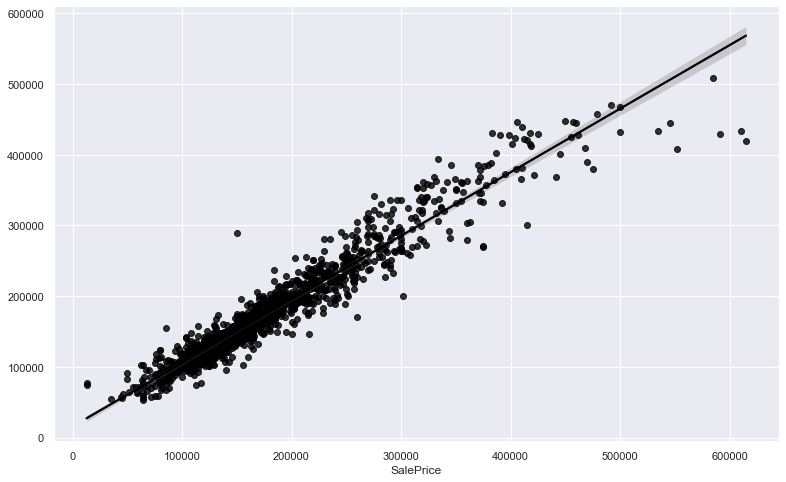

In [12]:
plt.figure(figsize=(13,8))
sns.regplot(x = cheat["SalePrice"], y = np.expm1(sub_predictions), color='black')